In [72]:
import pandas as pd
import numpy as np
import datetime as dt

from dbfread import DBF

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
from sklearn import preprocessing

In [3]:
def load_dbf_to_df(file_name):
    dbf = DBF(data_path + file_name, load=True, raw=True)
    df = pd.DataFrame(dbf.records)
    df.apply(lambda x: x.astype(str).str.upper())
    return df.applymap(lambda x: x.rstrip())

In [4]:
#pickle objects
def make_pickle(obj, filename):
    with open(filename, 'wb') as picklefile:
        pickle.dump(obj, picklefile)

## MassDEP Lead and Copper in School Drinking Water Sampling Results

In [5]:
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M:%S')

file_path = '../data/external/MassDEP/lcca/lccasampres02032017 - Results.csv'

schools = pd.read_csv(file_path,
                     parse_dates = ['COLLECTION_DATE'],
                     date_parser = dateparse,
                     na_values = 'NAN',
                     skipinitialspace = True)

In [6]:
schools.head()

,ORGCODE,TOWN,NAME,LOCATION_CODE,LOCATION_DESCRIPTION,LOCATION_TYPE,COLLECTION_DATE,ANALYTE_NAME,RESULT,REMEDIATION_ACTIONS_TAKEN
0,02070005,Waban,Newton: A E Angier,LCCA,"Angier--Close, 1st draw",NaN,2016-04-22 06:00:00,COPPER,0.195,NaN
1,02070005,Waban,Newton: A E Angier,LCCA,"Angier--Close, 1st draw",NaN,2016-04-22 06:00:00,LEAD,0.000191,NaN
2,02070005,Waban,Newton: A E Angier,LCCA,"Angier--Close, flush",NaN,2016-04-22 06:15:00,COPPER,0.13,NaN
3,02070005,Waban,Newton: A E Angier,LCCA,"Angier--Close, flush",NaN,2016-04-22 06:15:00,LEAD,0.000319,NaN
4,02070005,Waban,Newton: A E Angier,LCCA,"Angier--Far, 1st draw",NaN,2016-04-22 06:00:00,COPPER,0.194,NaN


In [7]:
schools.drop('REMEDIATION_ACTIONS_TAKEN', axis=1, inplace=True)

In [8]:
schools['LOCATION_TYPE'].fillna('Unknown', inplace=True)

In [9]:
#percent ND
float(len(schools[schools['RESULT'] == 'ND']))/len(schools)

0.2651284591973954

In [10]:
#replace ND with reasonable DL (0.005 mg/L)
schools.replace('ND', 0.0005, inplace=True)

In [11]:
schools = schools.apply(lambda x: x.astype(str).str.upper())
schools.applymap(lambda x: x.rstrip())
schools['RESULT'] = pd.to_numeric(schools['RESULT'])

### How many schools participated?

In [15]:
len(schools['ORGCODE'].value_counts())

875

### How many schools had one result above the action levels?

In [18]:
#action levels (mg/L)
pb_al = 0.015
cu_al = 1.3

In [30]:
def percent_above_al(df, al):
    percent = float(len(df[df['RESULT'] >= al]))/len(df)
    return round(percent*100, 2)

In [31]:
def above_al(df):
    pb = df[df['ANALYTE_NAME'] == 'LEAD']
    cu = df[df['ANALYTE_NAME'] == 'COPPER']
    print 'pb:', percent_above_al(pb, pb_al), '%'
    print 'cu:', percent_above_al(cu, cu_al), '%'

In [21]:
sch_grouped = schools.groupby(['NAME', 'ANALYTE_NAME'], as_index=False)

In [32]:
max_results = sch_grouped.max()
above_al(max_results)

pb: 55.77 %
cu: 23.14 %


In [34]:
max_results_pb = max_results[max_results['ANALYTE_NAME'] == 'LEAD']
max_results_pb.loc[max_results_pb['RESULT'] > pb_al, 'EXCEED'] = 1
max_results_pb['EXCEED'].fillna(0, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [51]:
exceeds = pd.DataFrame(max_results_pb['EXCEED'].value_counts())

In [118]:
exceeds.loc[exceeds['EXCEED'] == 485, 'LABEL'] = 'Above PBAL'
exceeds.loc[exceeds['EXCEED'] == 390, 'LABEL'] = 'Below PBAL'

In [59]:
485+390

875

In [65]:
exceeds['PERCENT'] = exceeds['EXCEED'].apply(lambda x: x/875.0*100)

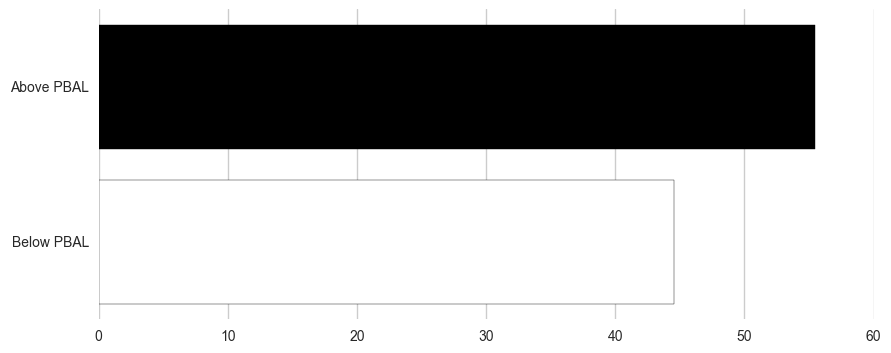

In [134]:
clrs = ['k' if (x == 'Above PBAL') else 'white' for x in exceeds['LABEL']]
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='PERCENT',
            y='LABEL',
            data=exceeds,
            palette=clrs)
ax.set(ylabel="",
       xlabel="")
sns.despine(left=True, bottom=True);

In [135]:
fig.savefig('../reports/figures/PBAL.png')

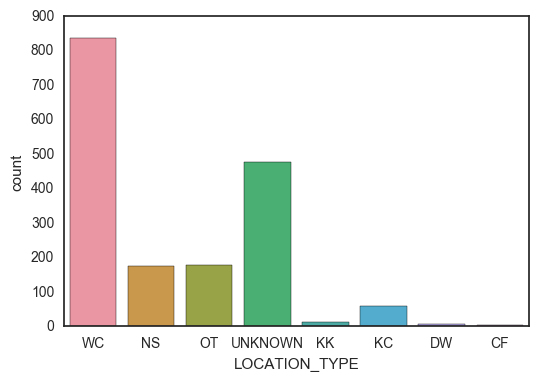

In [24]:
sns.countplot(max_results['LOCATION_TYPE']);

### At how many schools was the median of the samples above action levels?

In [25]:
median_results = sch_grouped.median()
above_al(median_results)

pb: 1.14 %
cu: 0.11 %


### At how many schools was the mean of the samples above action levels?

In [26]:
mean_results = sch_grouped.mean()
above_al(mean_results)

pb: 12.69 %
cu: 0.57 %


### At how many schools was the 90th percentile sample above action levels?

In [27]:
percentile_90 = sch_grouped.quantile(0.90).reset_index()
above_al(percentile_90)

pb: 19.09 %
cu: 3.89 %


### Join school building data to sampling results (lead only)

In [28]:
#only lead results
pb = max_results[max_results['ANALYTE_NAME'] == 'LEAD']

In [29]:
#load school building data
data_path = '../data/interim/'
bldgs = load_dbf_to_df('school_bldgs.dbf')

In [30]:
pb = pb.merge(bldgs, how='left', left_on='ORGCODE', right_on='SCHID')

### Join environmental justice data to sampling results

In [31]:
#load ej data
ej = load_dbf_to_df('ej_schools.dbf')

In [32]:
ej = pd.DataFrame(ej['SCHID'])

In [33]:
ej['EJ'] = 1

In [34]:
pb = pb.merge(ej, how='left', left_on='ORGCODE', right_on='SCHID')

In [35]:
pb['EJ'].fillna(0, inplace=True)

In [36]:
make_pickle(pb, '../data/interim/schools.pkl')

### Make csv with results for all schools for qgis (not sampled, below, above)

In [37]:
qgis_results = bldgs.merge(max_results[max_results['ANALYTE_NAME'] == 'LEAD'], how='left', left_on='SCHID', right_on='ORGCODE')

In [38]:
qgis_results = qgis_results[['SCHID', 'RESULT']]

In [39]:
qgis_results.loc[qgis_results['RESULT'] > pb_al, 'EXCEED'] = 'above'
qgis_results.loc[qgis_results['RESULT'] < pb_al, 'EXCEED'] = 'below'
qgis_results['EXCEED'].fillna('not sampled', inplace=True)

In [40]:
qgis_results.drop('RESULT', axis=1, inplace=True)

In [41]:
qgis_results.to_csv('../data/interim/school_results.csv')